In [1]:
import os
import numpy as np
import random

from common.loading import load_training_validation_data, load_test_data, create_generator, get_steps_per_epoch
from common.losses import monitor_mae, monitor_mse
from common.testing import get_counts, predict_counts, get_mae_rmse, save_test_results, plot_prediction
from common.training import prepare_output_dirs, create_weights_callbacks, create_tensorboard_callback, create_early_stopping_callback, read_history, plot_losses, save_losses
from common.utils import get_flops, print_flops
from datetime import datetime
from importlib import reload
from keras.models import load_model
from keras.optimizers import Adam
from models import MobileCount

# Settings
dataset = "B"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib inline
SEED = 31415
np.random.seed(SEED)
random.seed(SEED)

Using TensorFlow backend.


## Training data loading

In [14]:
train_img, train_labels, validation_img, validation_labels = load_training_validation_data(dataset)

Loaded training images
Loaded training density maps
Loaded validation images
Loaded validation density maps


## Model definition

In [2]:
# if model changed, reload it
reload(MobileCount)

epochs = 10
batch_size = 5
model_name = 'mobilecount'
submodel_name = 'base'

weights_val_path = os.path.join('weights', f'{model_name}_{submodel_name}_{dataset}_val.hdf5')
weights_train_path = os.path.join('weights', f'{model_name}_{submodel_name}_{dataset}_train.hdf5')
res_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_{model_name}_{submodel_name}"

if os.path.exists(weights_val_path):
    os.remove(weights_val_path)

if os.path.exists(weights_train_path):
    os.remove(weights_train_path)

callbacks = [
    *create_weights_callbacks(weights_train_path, weights_val_path),
    create_tensorboard_callback(),
    create_early_stopping_callback()
]

custom_objects={'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse}

model = MobileCount.MobileCount((192, 256, 1))
model._get_distribution_strategy = lambda: None
adam = Adam()
model.compile(loss='mean_squared_error', optimizer=adam,
              metrics=[monitor_mae, monitor_mse])
# DON'T use summary, there are too many layers because of grouping
# model.summary()
model.count_params()

3455009

## Training

In [4]:
prepare_output_dirs()

In [5]:
history = model.fit(
    x=create_generator(train_img, train_labels, batch_size),
    steps_per_epoch=get_steps_per_epoch(train_img, train_labels, batch_size),
    epochs=epochs,
    validation_data=create_generator(validation_img, validation_labels, 1),
    validation_steps=get_steps_per_epoch(validation_img, validation_labels, 1),
    callbacks=callbacks
)

Epoch 1/10
720/720 [==============================] - 2418s 3s/step - loss: 0.5673 - monitor_mae: 28480.7422 - monitor_mse: 139421.1719 - val_loss: 8.8258e-04 - val_monitor_mae: 246.9462 - val_monitor_mse: 11.5264

Epoch 00001: val_loss improved from inf to 0.00088, saving model to weights\mobilecount_base_B_val.hdf5

Epoch 00001: loss improved from inf to 0.56731, saving model to weights\mobilecount_base_B_train.hdf5
Epoch 2/10
720/720 [==============================] - 1853s 3s/step - loss: 1.6636e-05 - monitor_mae: 141.4174 - monitor_mse: 4.0885 - val_loss: 1.4187e-04 - val_monitor_mae: 116.8217 - val_monitor_mse: 9.0183

Epoch 00002: val_loss improved from 0.00088 to 0.00014, saving model to weights\mobilecount_base_B_val.hdf5

Epoch 00002: loss improved from 0.56731 to 0.00002, saving model to weights\mobilecount_base_B_train.hdf5
Epoch 3/10
720/720 [==============================] - 1834s 3s/step - loss: 6.9983e-06 - monitor_mae: 61.0313 - monitor_mse: 1.7199 - val_loss: 6.1862e-

## Analyze training

2020-11-08_02-49-58_mobilecount_base


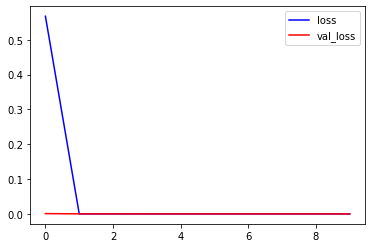

In [6]:
loss, val_loss = read_history(history)
plot_losses(loss, val_loss)
save_losses(loss, val_loss, res_name)
print(res_name)

## Test data loading

In [11]:
test_img, test_labels = load_test_data(dataset)

Loaded test images
Loaded test density maps


## Test

In [ ]:
def test_model(train_or_val):
    weights_path = eval(f'weights_{train_or_val}_path')

    model = load_model(weights_path, custom_objects=custom_objects, compile=False)

    targets = get_counts(test_labels)
    predictions = predict_counts(model, test_img)

    mae, rmse = get_mae_rmse(targets, predictions)

    save_test_results(model, mae, rmse, res_name, train_or_val, weights_path)

    print(res_name + ' ' + train_or_val)
    print(f'MAE: {mae}, RMSE: {rmse}')

test_model('train')
test_model('val')

## Results presentation

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.65s/it]
D:\inzynierka\inzynierka\common\testing.py:62: RuntimeWarning: divide by zero encountered in double_scalars
  ax1.imshow(target_dm * (255 / (np.max(target_dm) - np.min(target_dm))), cmap='gray')
D:\inzynierka\inzynierka\common\testing.py:62: RuntimeWarning: invalid value encountered in multiply
  ax1.imshow(target_dm * (255 / (np.max(target_dm) - np.min(target_dm))), cmap='gray')
D:\Programy\Conda\envs\mmnet-win\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
D:\Programy\Conda\envs\mmnet-win\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
D:\Programy\Conda\envs\mmnet-win\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a

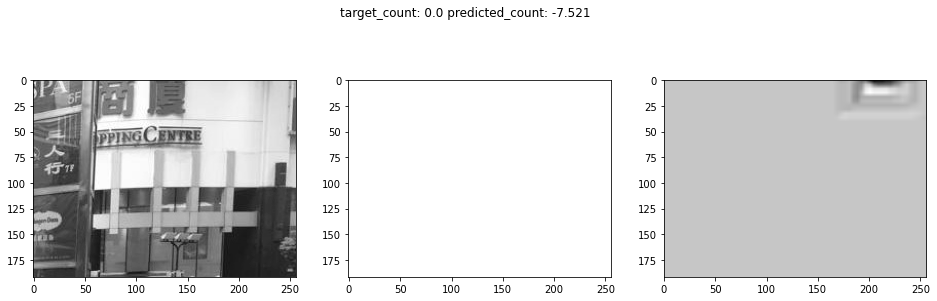

D:\inzynierka\inzynierka\common\testing.py:63: RuntimeWarning: divide by zero encountered in true_divide
  ax2.imshow(predicted_dm * (255 / (np.max(predicted_dm) - np.min(predicted_dm))), cmap='gray')


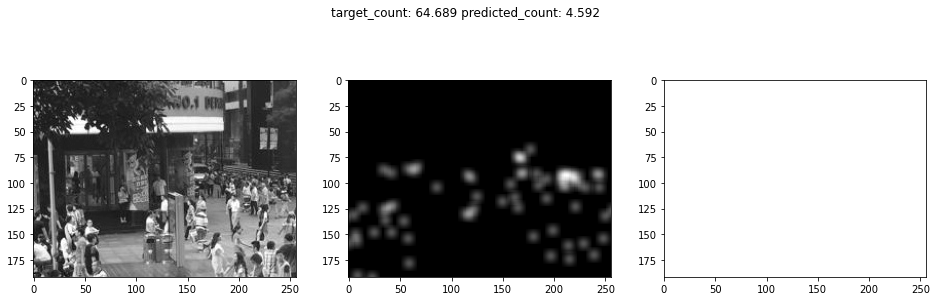

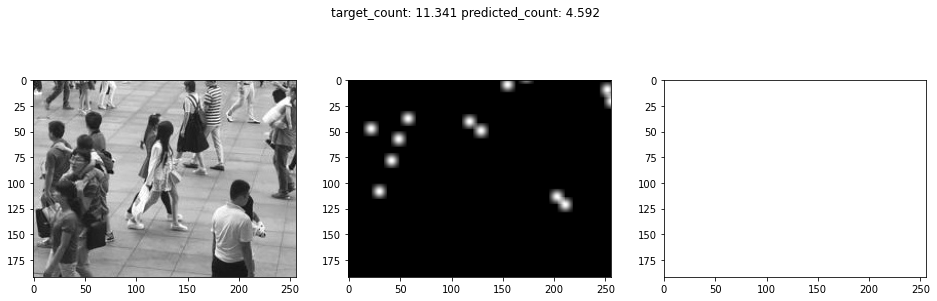

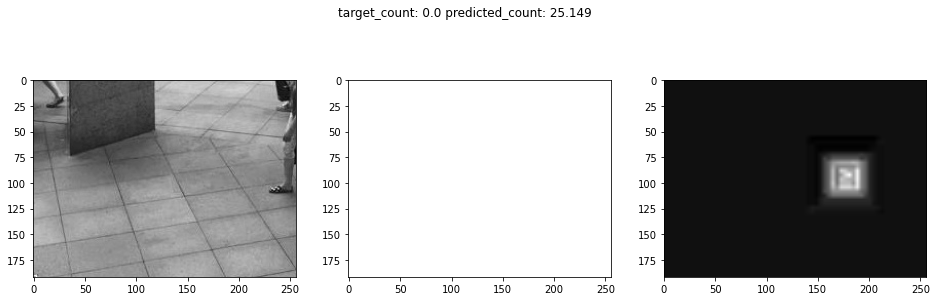

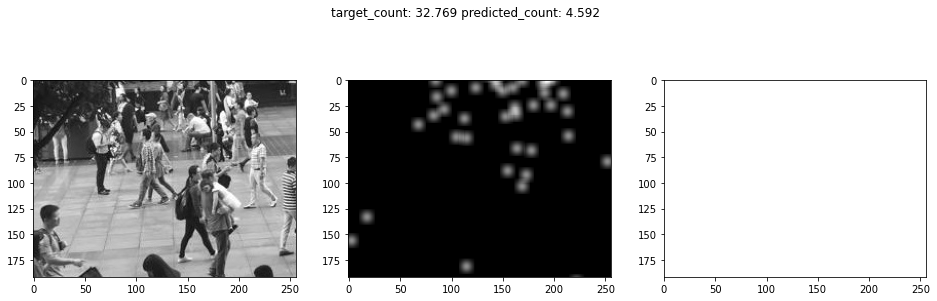

MAE: 25.53797441948731, RMSE: 32.06240628916388


In [16]:
def present_results(train_or_val_weights, tests_num=5):
    model = load_model(eval(f'weights_{train_or_val_weights}_path'), custom_objects=custom_objects, compile=False)

    images = train_img[:tests_num]
    labels = train_labels[:tests_num]

    target_counts, target_dms = get_counts(labels), labels
    predicted_counts, predicted_dms = predict_counts(model, images, True)

    for image, target_count, target_dm, predicted_count, predicted_dm in zip(images, target_counts, target_dms, predicted_counts, predicted_dms):
        plot_prediction(image, target_count, target_dm, predicted_count, predicted_dm)

    mae, rmse = get_mae_rmse(target_counts, predicted_counts)
    print(f'MAE: {mae}, RMSE: {rmse}')

present_results('val')

## Profiling

In [3]:
def sumprint(s):
    with open('mobilecount-modelsummary.txt','w+') as f:
        print(s, file=f)

model.summary(print_fn=sumprint)
flops = get_flops(weights_val_path, custom_objects)
print_flops(flops, model)

OSError: Unable to open file (unable to open file: name = 'weights\mobilecount_base_B_val.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)